# Spark Session

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("GHG_Emissions_and_Temperatures").getOrCreate()


24/05/20 01:59:06 WARN Utils: Your hostname, Parths-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.117 instead (on interface en0)
24/05/20 01:59:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/20 01:59:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# reading datasets

In [2]:
ghg_df = spark.read.csv("ghg-emissions-by-gas.csv", header=True, inferSchema=True)
temp_df = spark.read.csv("GlobalLandTemperaturesByCountry.csv", header=True, inferSchema=True)

## looking at the columns of datasets

In [3]:
ghg_df.show()
temp_df.show()

+-----------+----+----+-------------------------------------------------+-------------------------------------------+--------------------+
|     Entity|Code|Year|Annual nitrous oxide emissions in CO₂ equivalents|Annual methane emissions in CO₂ equivalents|Annual CO₂ emissions|
+-----------+----+----+-------------------------------------------------+-------------------------------------------+--------------------+
|Afghanistan| AFG|1850|                                         223008.4|                                  3594926.5|           3520884.0|
|Afghanistan| AFG|1851|                                        227659.61|                                  3615134.5|           3561188.2|
|Afghanistan| AFG|1852|                                        232190.92|                                  3635346.8|           3596619.0|
|Afghanistan| AFG|1853|                                        236528.19|                                  3655563.5|           3630340.0|
|Afghanistan| AFG|1854|    

# cleaning data

In [4]:

ghg_df = ghg_df.na.drop()
temp_df = temp_df.na.drop()

In [5]:
ghg_df = ghg_df.withColumn("Year", col("Year").cast("int"))
temp_df = temp_df.withColumn("dt", col("dt").cast("date"))

In [6]:
ghg_df = ghg_df.dropDuplicates()
temp_df = temp_df.dropDuplicates()

In [7]:
from pyspark.sql.functions import year , avg
# Extract year from date in temperature data
temp_df = temp_df.withColumn("Year", year(temp_df["dt"]))

In [8]:
# Rename 'Entity' to 'Country' in the GHG DataFrame
ghg_df = ghg_df.withColumnRenamed("Entity", "Country")

In [9]:
# Aggregate temperature data by year and country
temp_agg_df = temp_df.groupBy("Year", "Country").agg(avg("AverageTemperature").alias("AvgTemperature"))

## Joining datasets on Year and Country

In [10]:

combined_df = ghg_df.join(temp_agg_df, on=["Year", "Country"], how="inner")

In [11]:
combined_df.show()

+----+-----------+----+-------------------------------------------------+-------------------------------------------+--------------------+------------------+
|Year|    Country|Code|Annual nitrous oxide emissions in CO₂ equivalents|Annual methane emissions in CO₂ equivalents|Annual CO₂ emissions|    AvgTemperature|
+----+-----------+----+-------------------------------------------------+-------------------------------------------+--------------------+------------------+
|2001|    Burundi| BDI|                                         753425.9|                                  2590731.5|           3142270.8|20.510333333333335|
|1917| Azerbaijan| AZE|                                         586049.5|                                  1147788.9|           4045823.5|11.882166666666668|
|1977|     Bhutan| BTN|                                         91214.16|                                   589346.3|           8121988.5|          12.00475|
|1989|    Belgium| BEL|                             

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Convert combined data to Pandas for visualization
combined_pd_df = combined_df.toPandas()

24/05/20 01:59:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


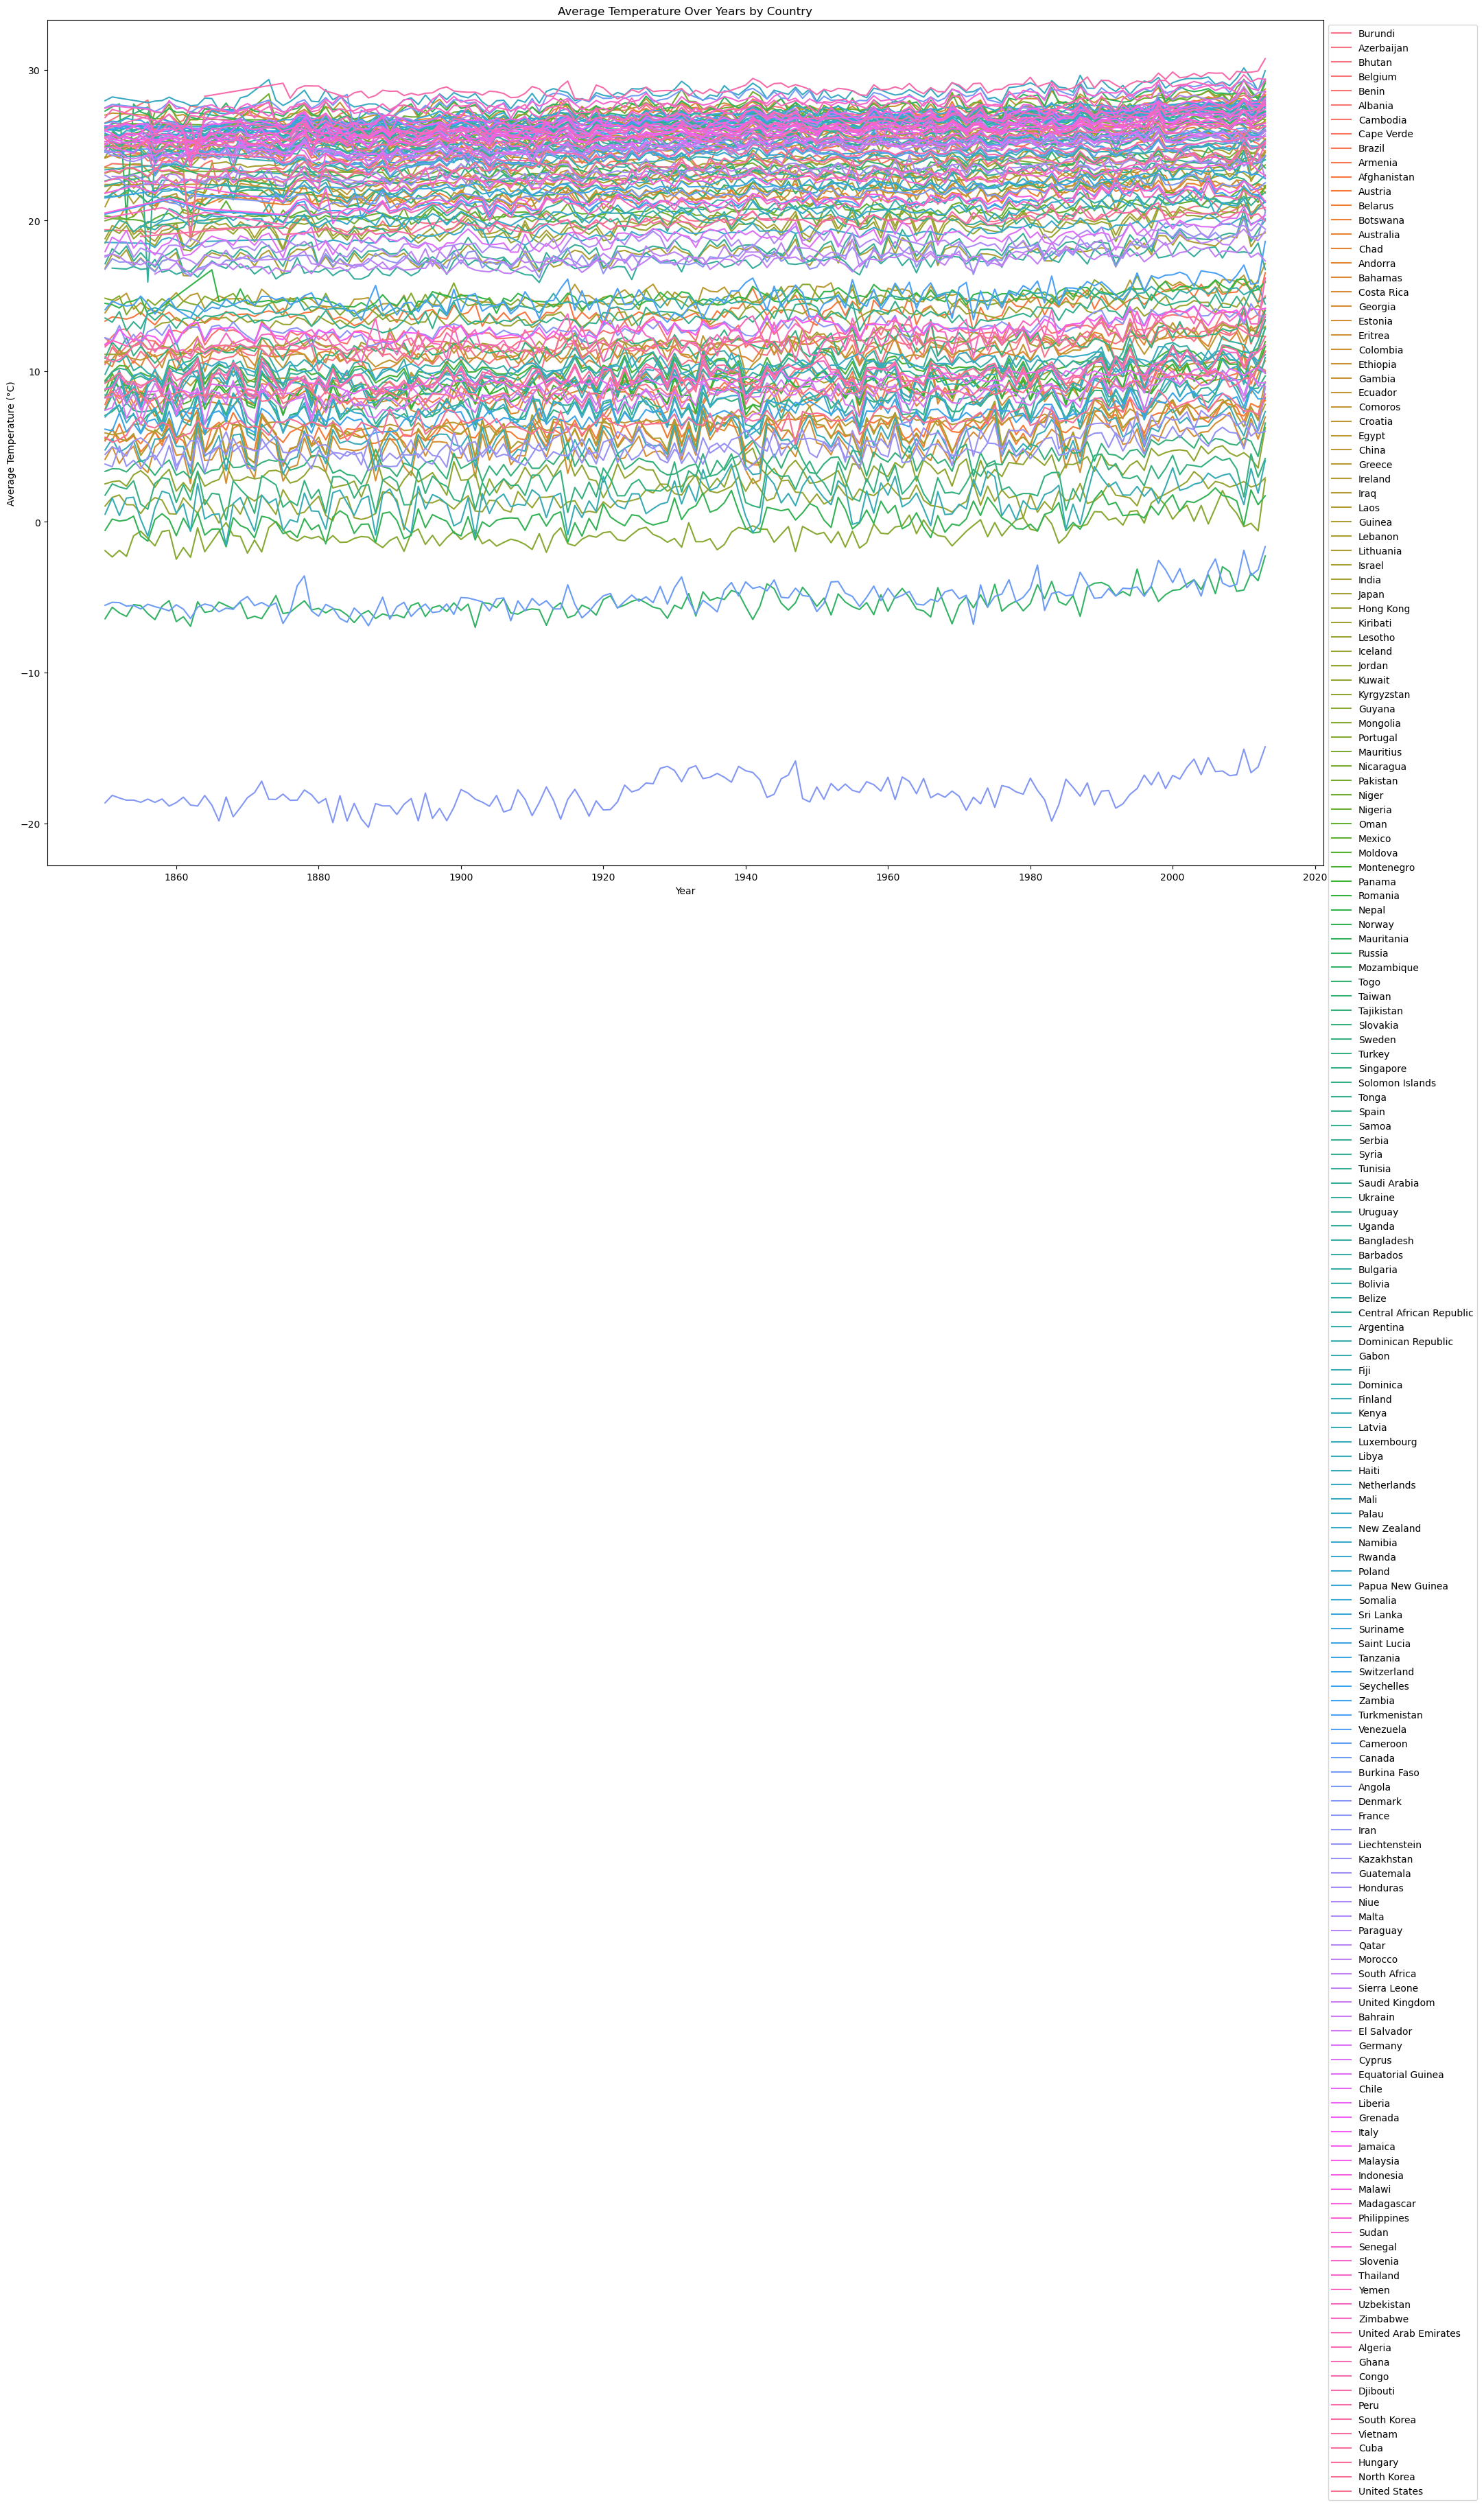

In [14]:
plt.figure(figsize=(24, 16))
sns.lineplot(data=combined_pd_df, x="Year", y="AvgTemperature", hue="Country")
plt.title("Average Temperature Over Years by Country")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [15]:
print(combined_pd_df.columns)


Index(['Year', 'Country', 'Code',
       'Annual nitrous oxide emissions in CO₂ equivalents',
       'Annual methane emissions in CO₂ equivalents', 'Annual CO₂ emissions',
       'AvgTemperature'],
      dtype='object')


# Temperature Anomalies vs GHG Emissions:

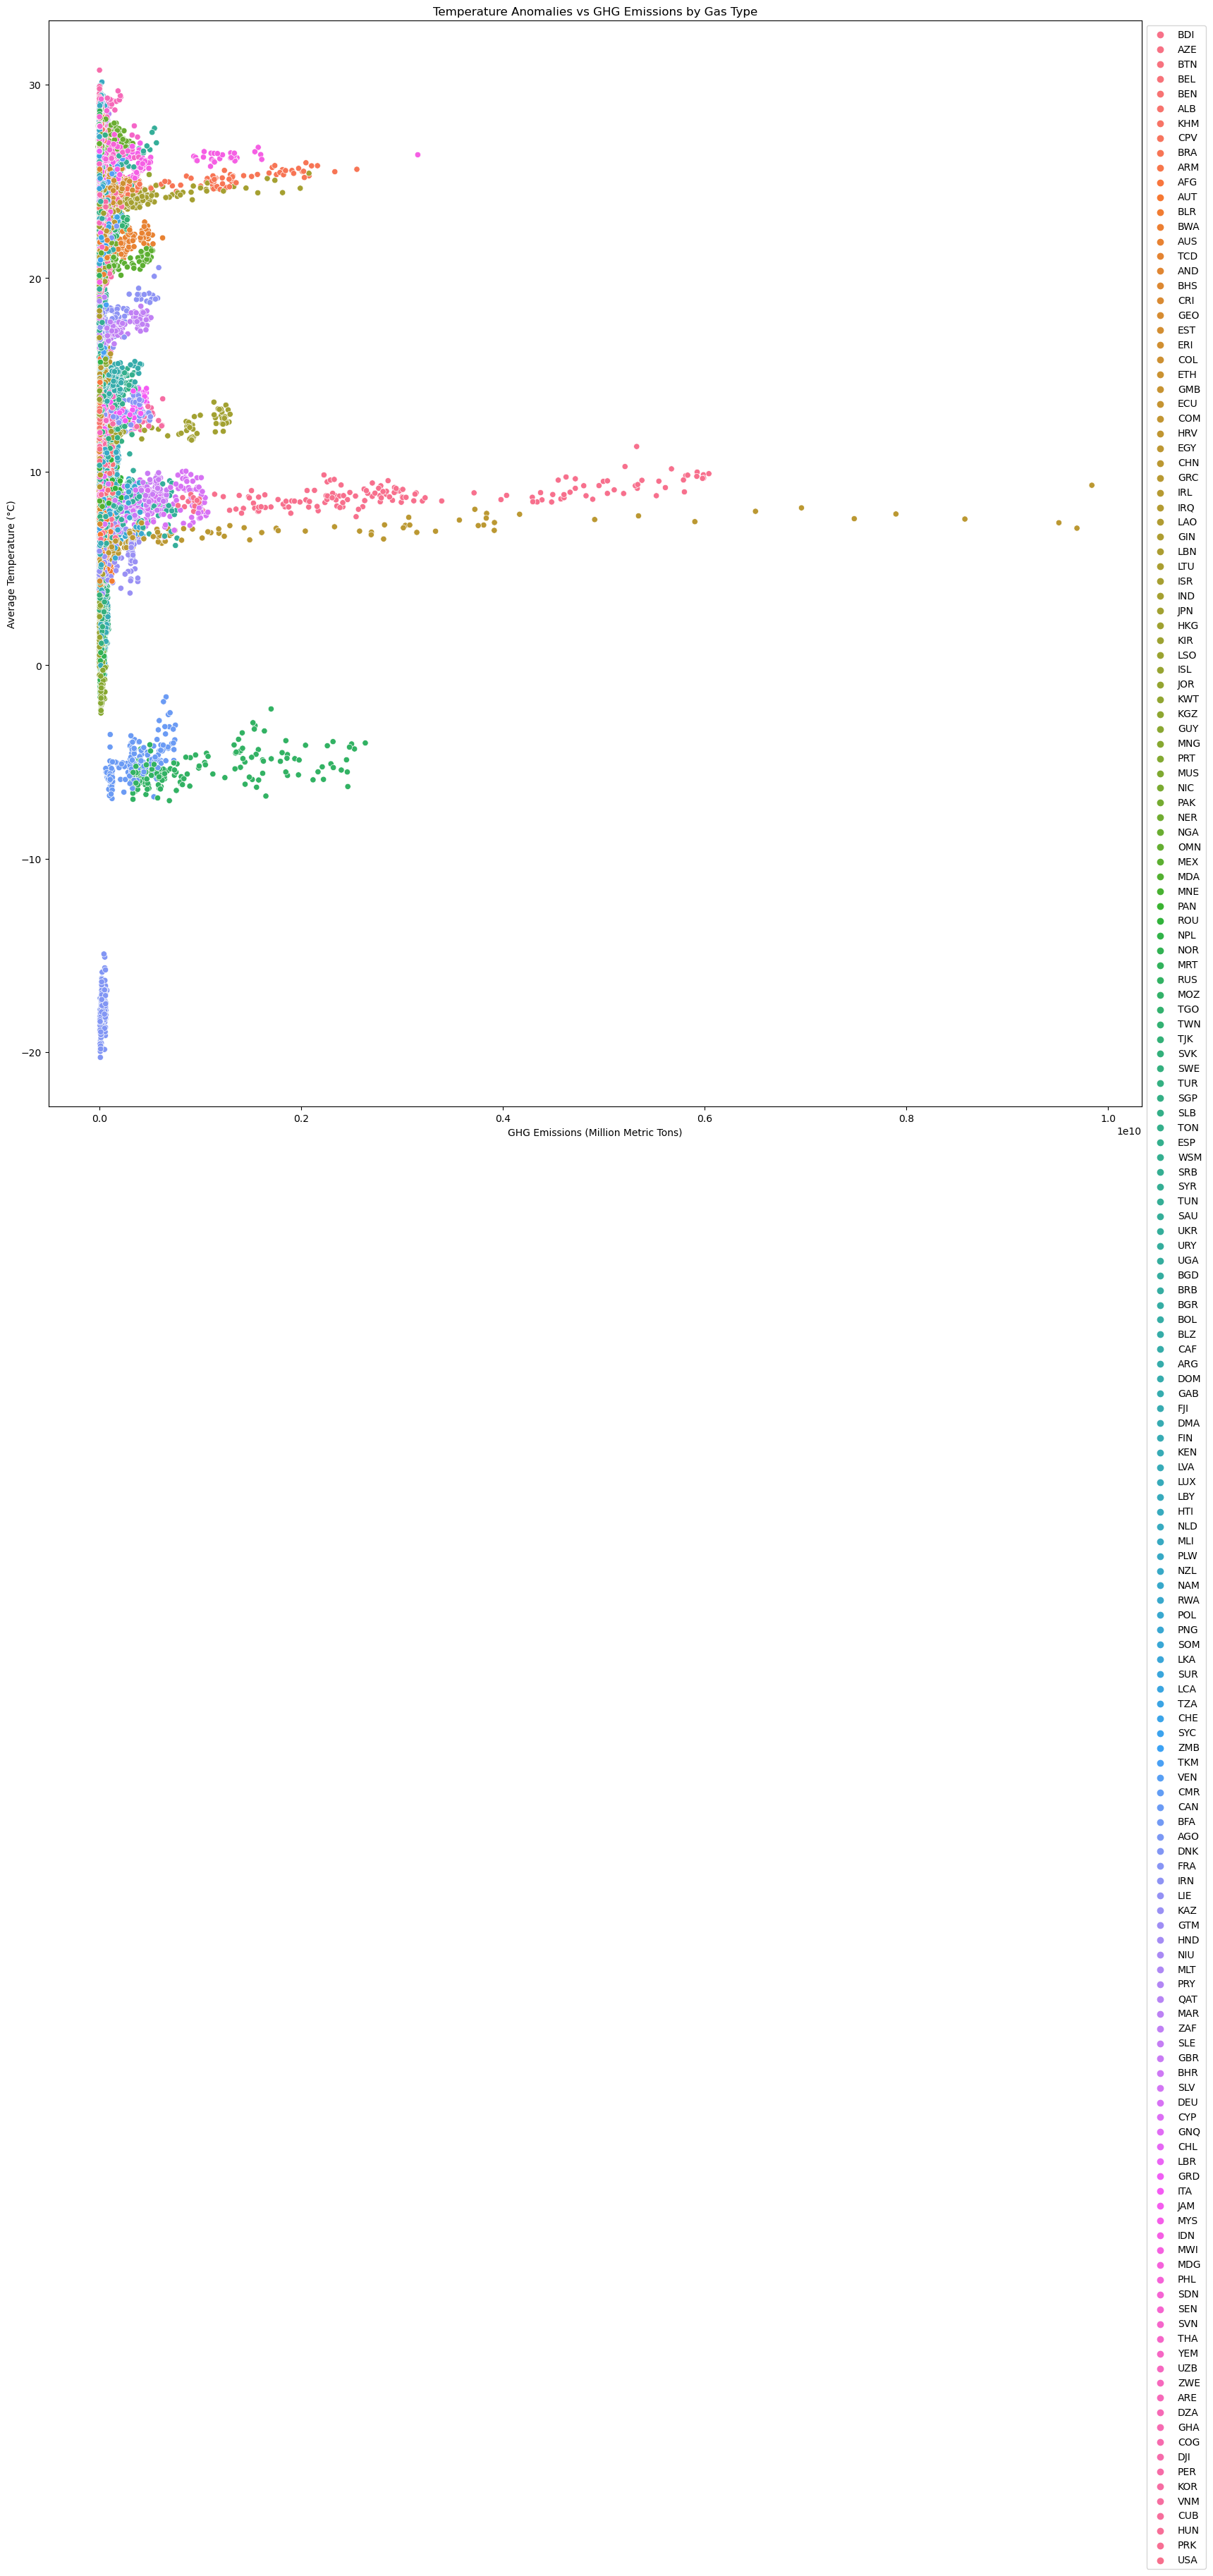

In [16]:
# Renaming columns to remove any issues with special characters or spaces
combined_pd_df = combined_pd_df.rename(columns={
    'Annual CO₂ emissions': 'GHG_Emissions',
    'AvgTemperature': 'AvgTemperature',
    'Code': 'Gas_Type'
})

# Create the scatter plot again with the new column names
plt.figure(figsize=(20, 20))
sns.scatterplot(data=combined_pd_df, x="GHG_Emissions", y="AvgTemperature", hue="Gas_Type")
plt.title("Temperature Anomalies vs GHG Emissions by Gas Type")
plt.xlabel("GHG Emissions (Million Metric Tons)")
plt.ylabel("Average Temperature (°C)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


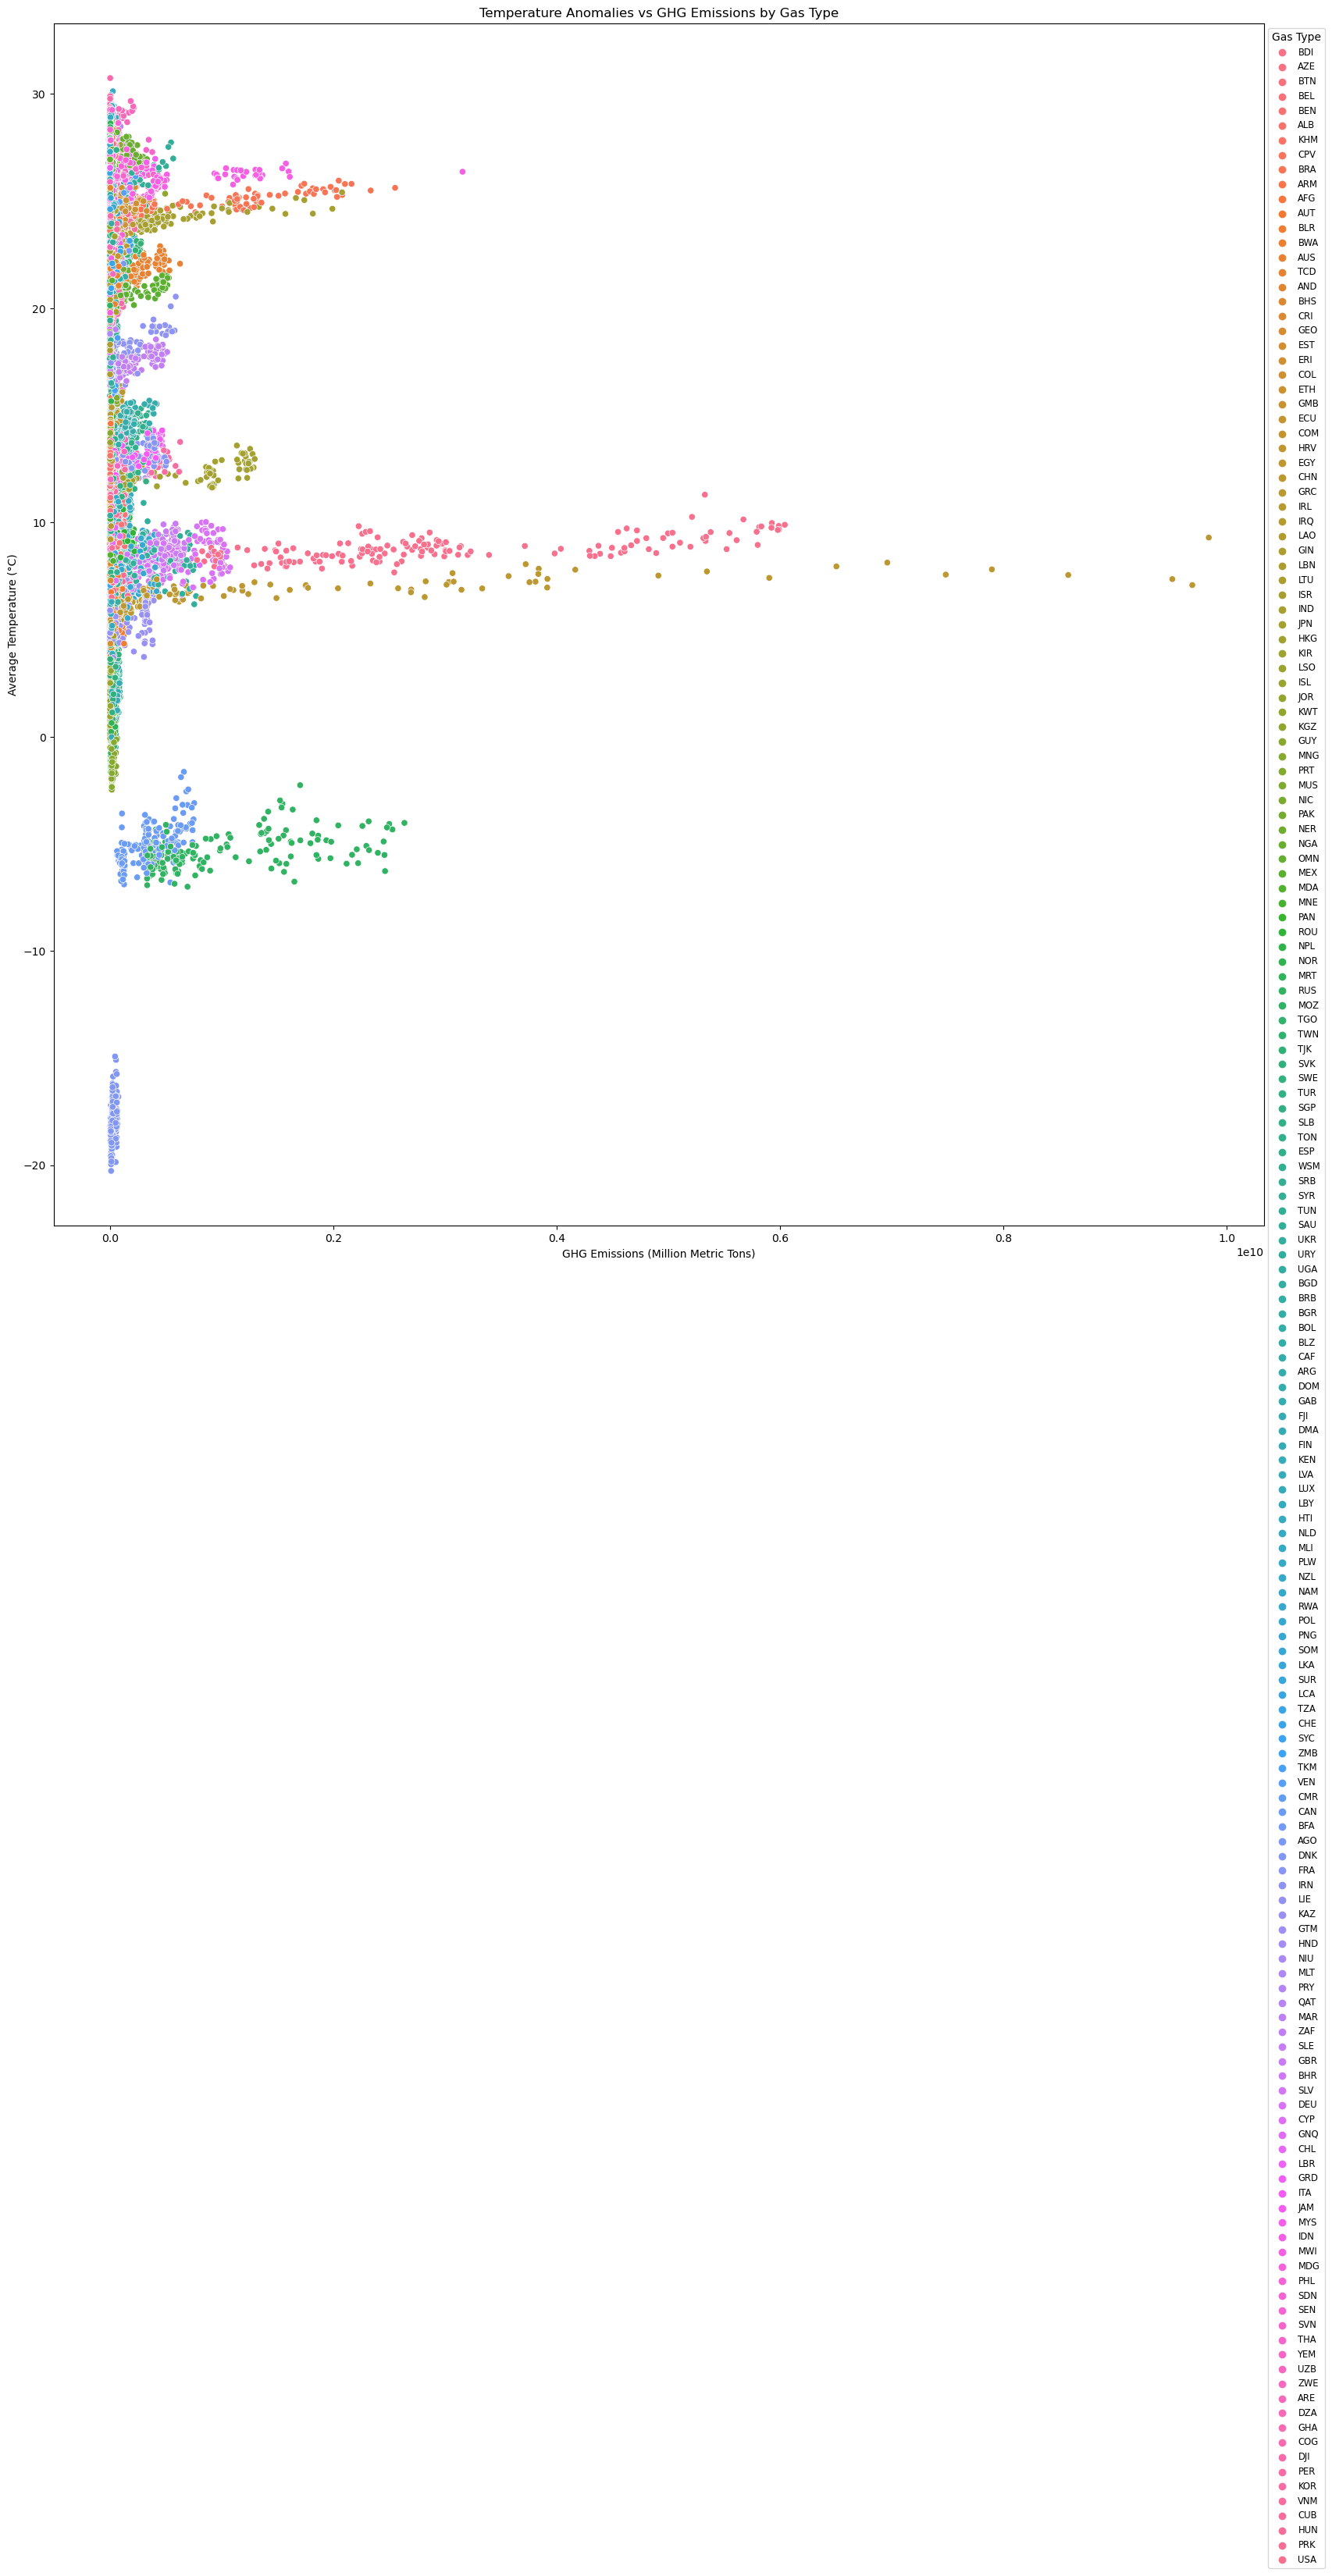

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Renaming columns to remove any issues with special characters or spaces
combined_pd_df = combined_pd_df.rename(columns={
    'Annual CO₂ emissions': 'GHG_Emissions',
    'AvgTemperature': 'AvgTemperature',
    'Code': 'Gas_Type'
})

# Create the scatter plot again with the new column names
plt.figure(figsize=(20, 20))
scatter_plot = sns.scatterplot(data=combined_pd_df, x="GHG_Emissions", y="AvgTemperature", hue="Gas_Type")
plt.title("Temperature Anomalies vs GHG Emissions by Gas Type")
plt.xlabel("GHG Emissions (Million Metric Tons)")
plt.ylabel("Average Temperature (°C)")

# Adjust legend to be within figure boundaries
scatter_plot.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Gas Type', fontsize='small', title_fontsize='medium')

plt.show()

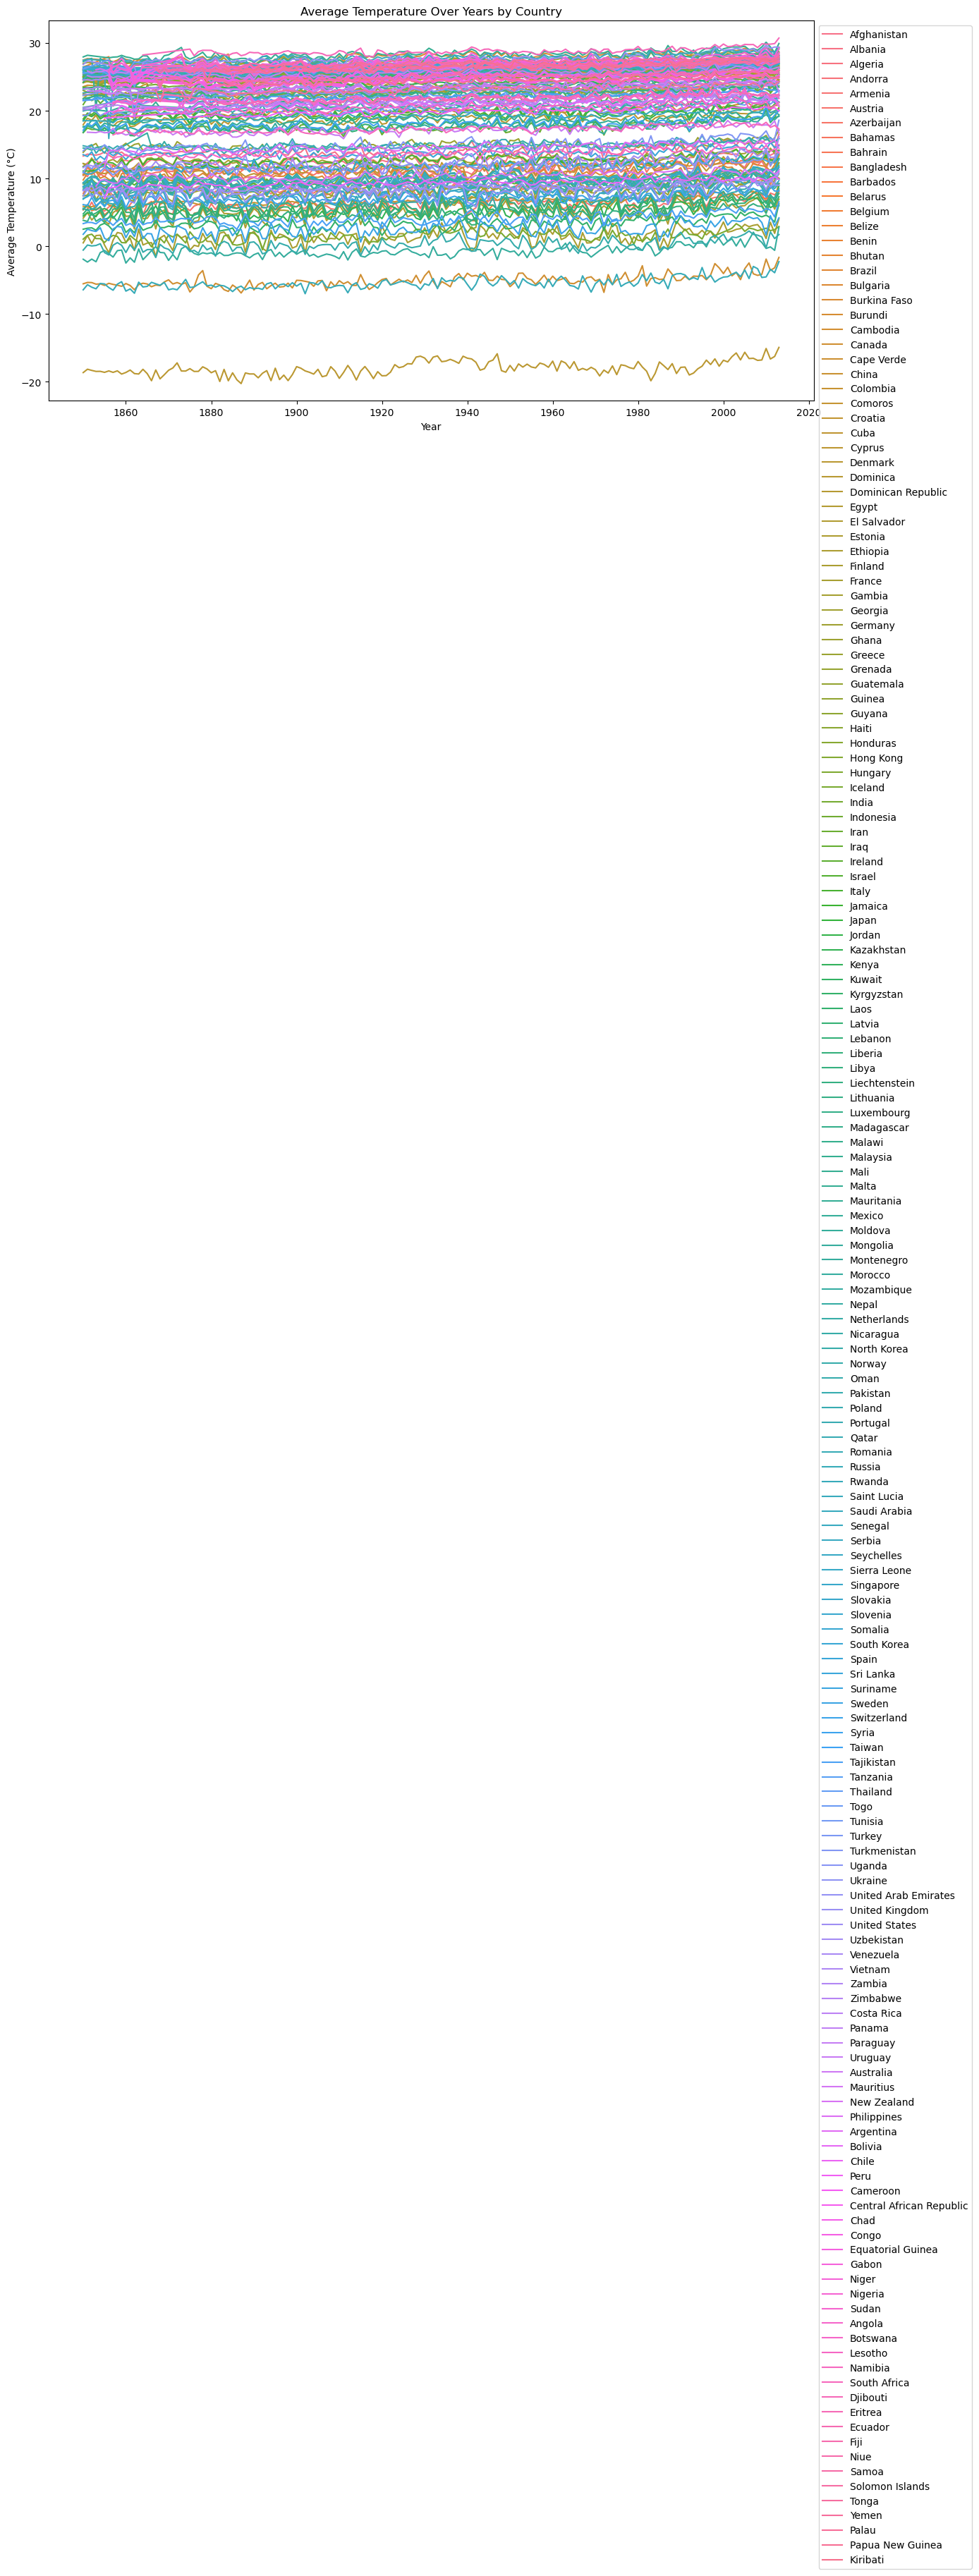

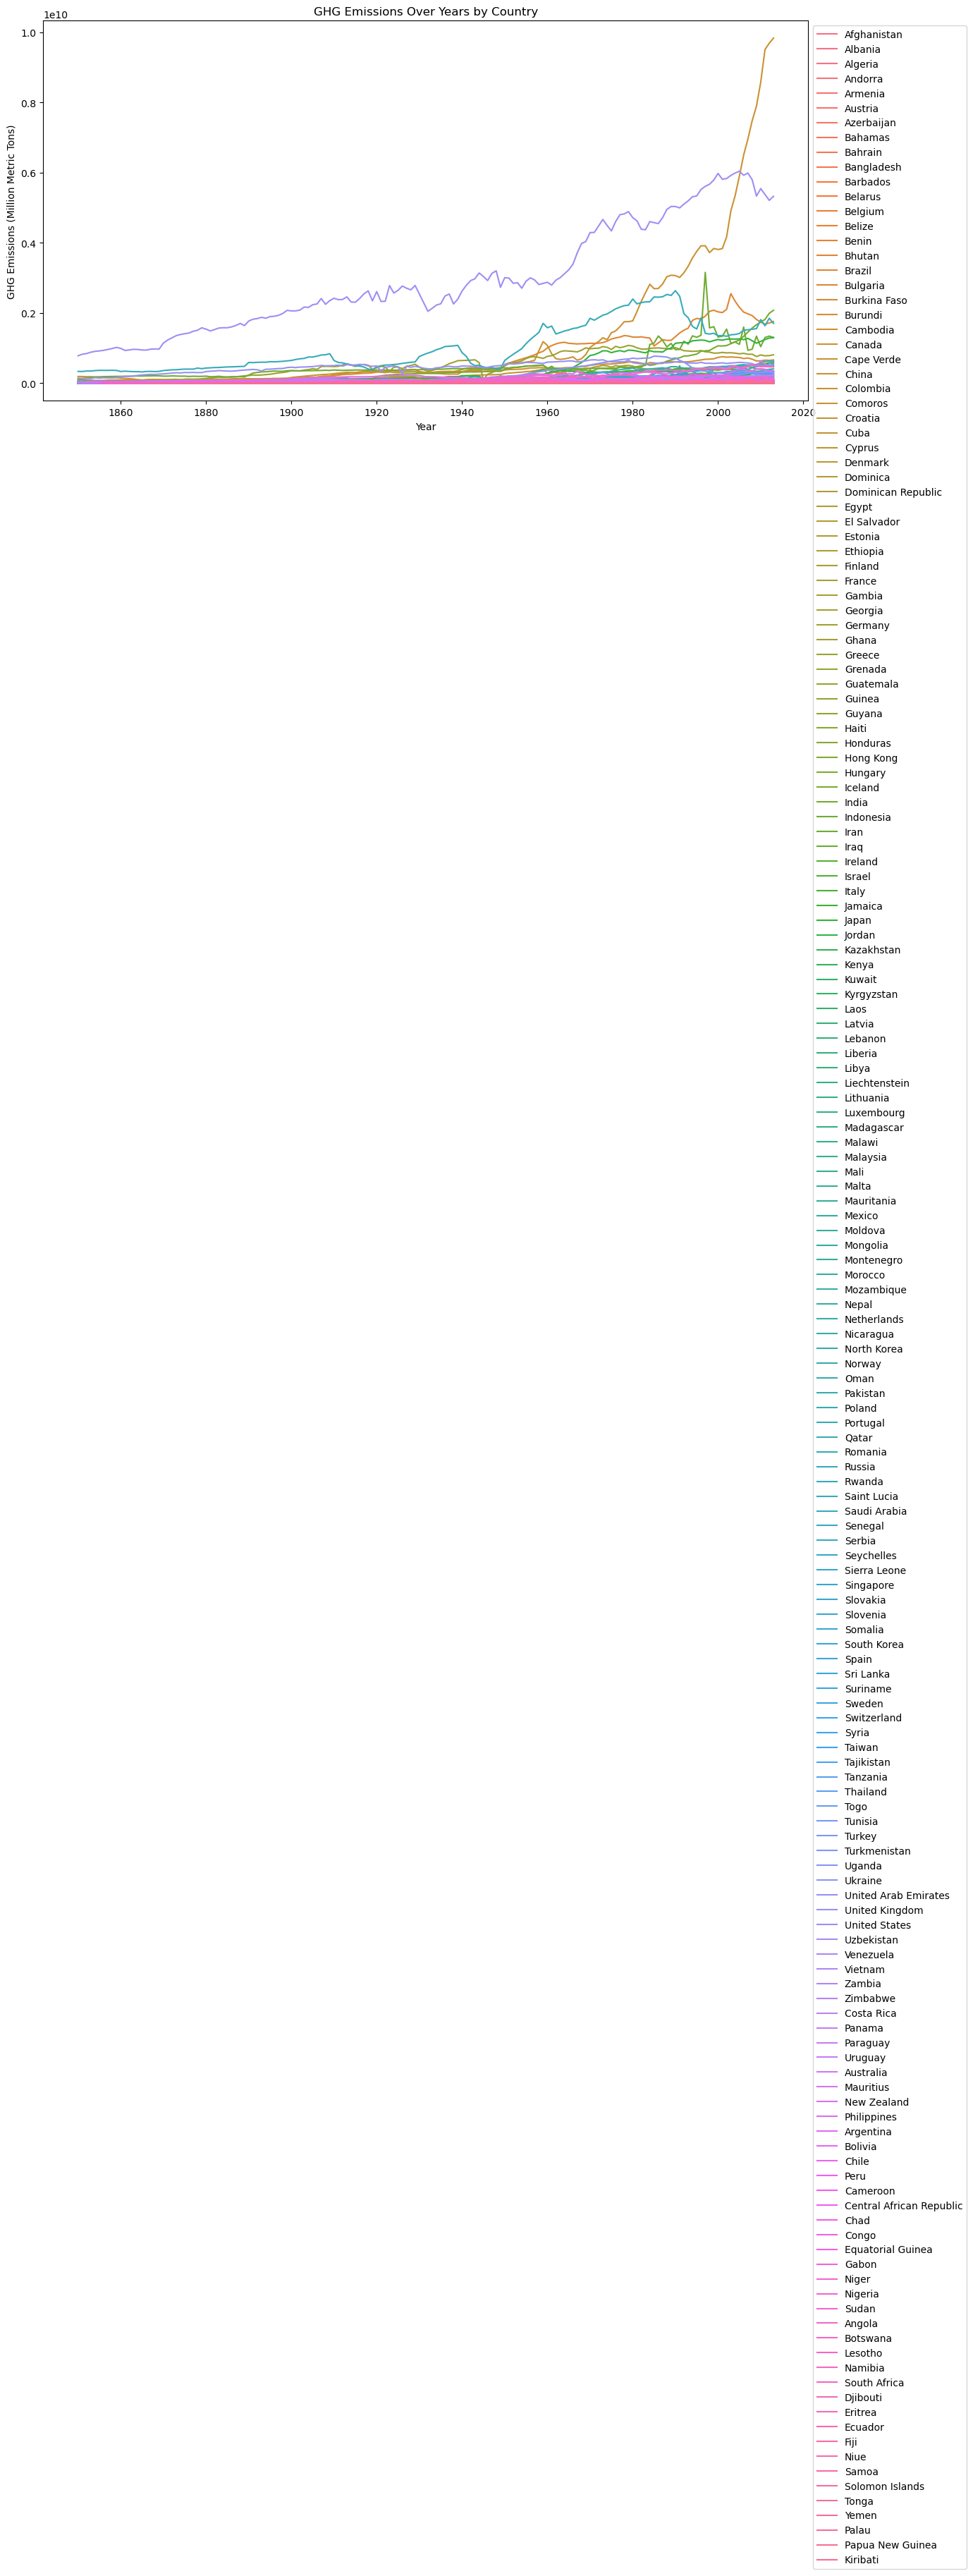

In [18]:
# Group by region (Country) and year
regional_temp = combined_pd_df.groupby(['Year', 'Country']).agg({'AvgTemperature': 'mean'}).reset_index()
regional_ghg = combined_pd_df.groupby(['Year', 'Country']).agg({'GHG_Emissions': 'sum'}).reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(data=regional_temp, x="Year", y="AvgTemperature", hue="Country")
plt.title("Average Temperature Over Years by Country")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

plt.figure(figsize=(14, 7))
sns.lineplot(data=regional_ghg, x="Year", y="GHG_Emissions", hue="Country")
plt.title("GHG Emissions Over Years by Country")
plt.xlabel("Year")
plt.ylabel("GHG Emissions (Million Metric Tons)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


# correlation matrix

                                                       Year  \
Year                                               1.000000   
Annual nitrous oxide emissions in CO₂ equivalents  0.210135   
Annual methane emissions in CO₂ equivalents        0.175055   
GHG_Emissions                                      0.149752   
AvgTemperature                                     0.083398   

                                                   Annual nitrous oxide emissions in CO₂ equivalents  \
Year                                                                                        0.210135   
Annual nitrous oxide emissions in CO₂ equivalents                                           1.000000   
Annual methane emissions in CO₂ equivalents                                                 0.941509   
GHG_Emissions                                                                               0.898712   
AvgTemperature                                                                             -0.138255 

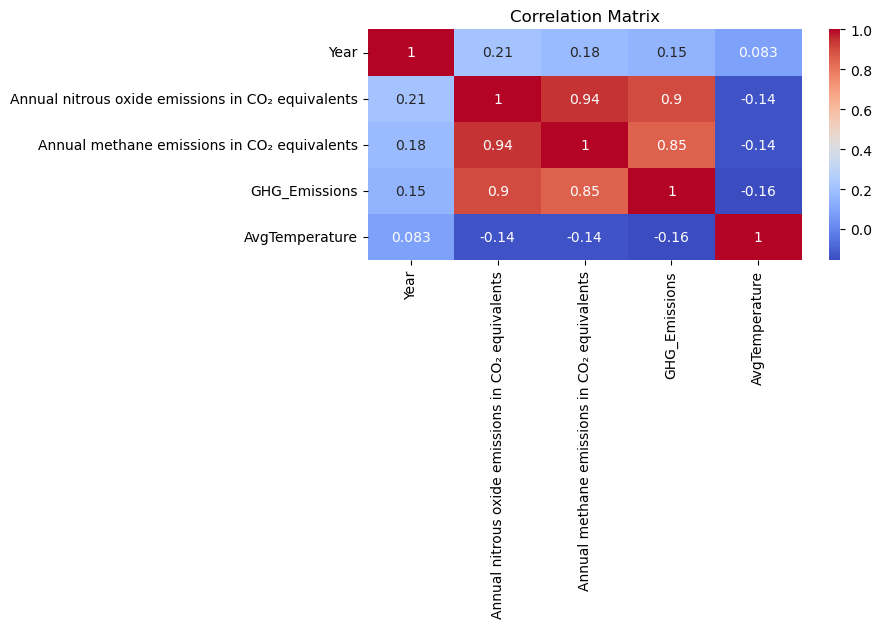

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


numeric_df = combined_pd_df.select_dtypes(include=[float, int])


correlation_matrix = numeric_df.corr()
print(correlation_matrix)


plt.figure(figsize=(7, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


# Relationship between global temperature anomalies and greenhouse gas emissions:

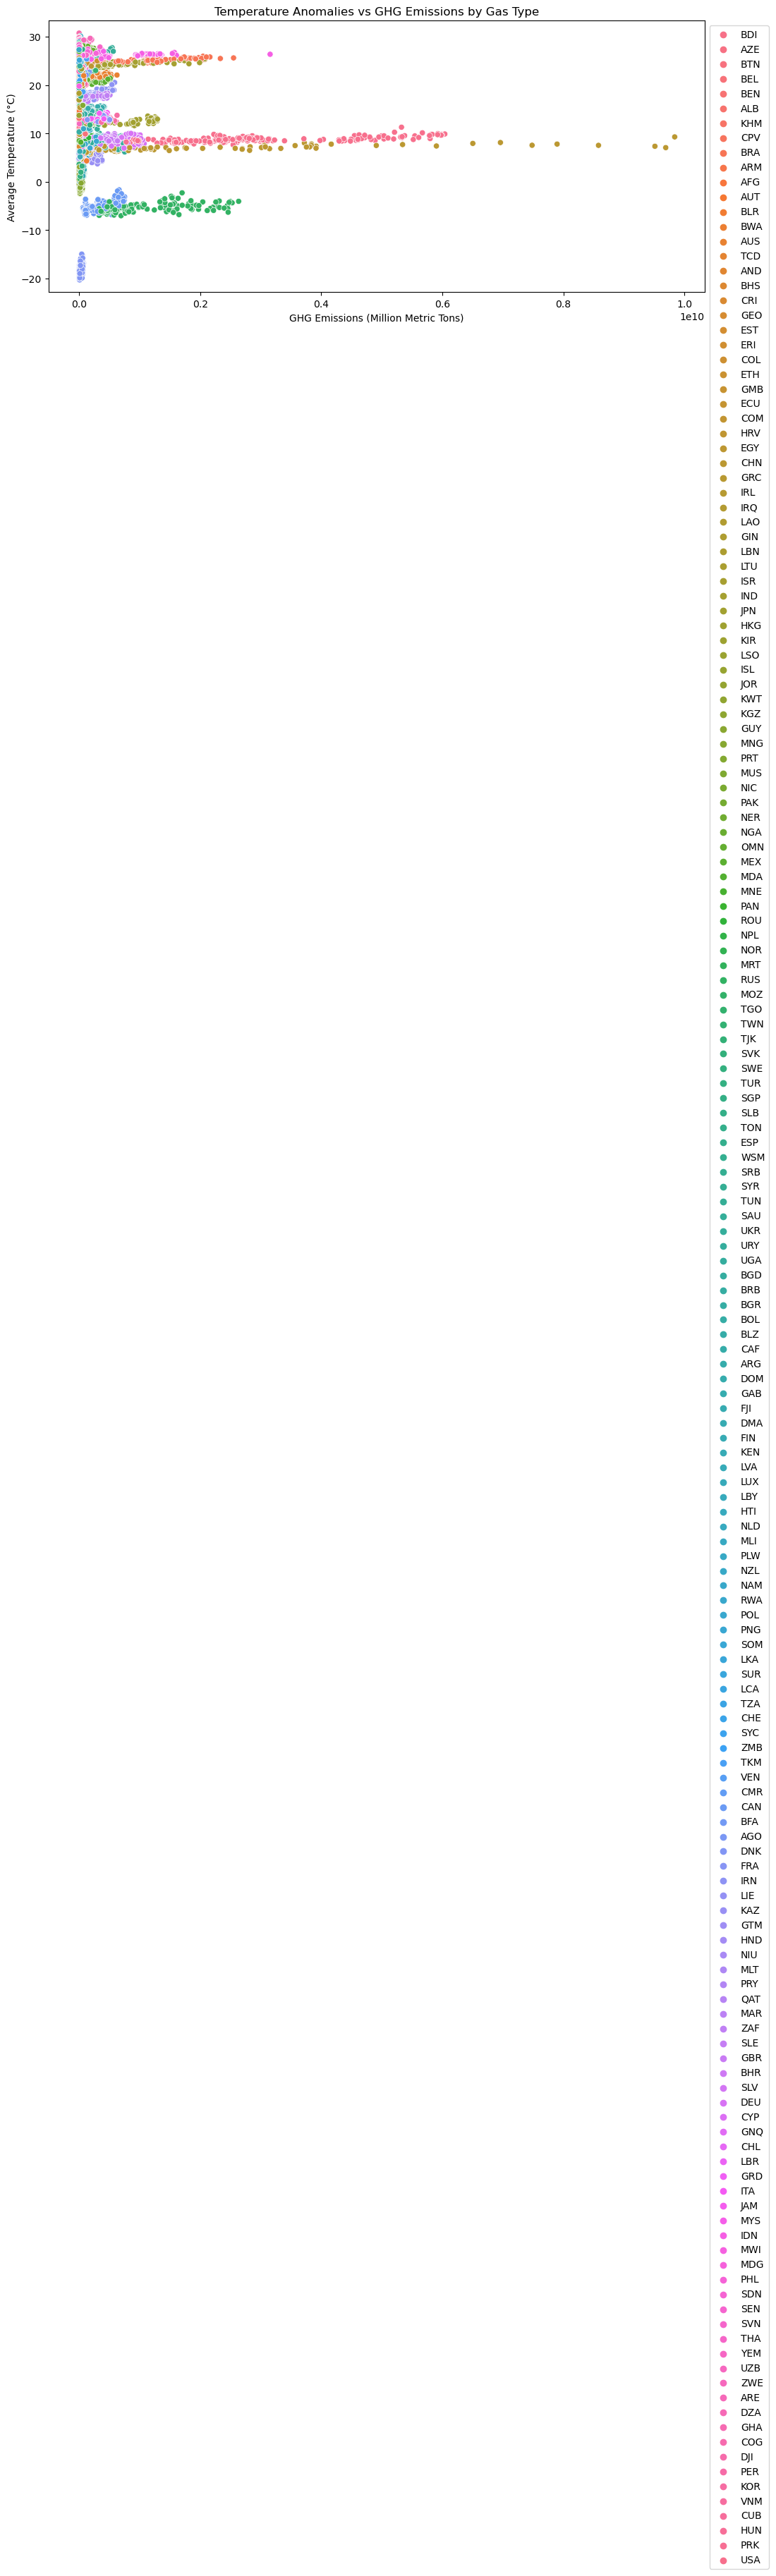

                            OLS Regression Results                            
Dep. Variable:         AvgTemperature   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     688.1
Date:                Mon, 20 May 2024   Prob (F-statistic):          8.59e-150
Time:                        01:59:30   Log-Likelihood:                -97138.
No. Observations:               27135   AIC:                         1.943e+05
Df Residuals:                   27133   BIC:                         1.943e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            18.6525      0.054    345.678

In [20]:
# Plotting temperature anomalies vs GHG emissions
plt.figure(figsize=(12, 5))
sns.scatterplot(data=combined_pd_df, x="GHG_Emissions", y="AvgTemperature", hue="Gas_Type")
plt.title("Temperature Anomalies vs GHG Emissions by Gas Type")
plt.xlabel("GHG Emissions (Million Metric Tons)")
plt.ylabel("Average Temperature (°C)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Linear Regression Analysis
import statsmodels.api as sm

X = combined_pd_df["GHG_Emissions"]
y = combined_pd_df["AvgTemperature"]

X = sm.add_constant(X)  # Adding a constant
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the statistics
print(model.summary())


# Differences in greenhouse gas emissions between regions and their effect on global temperatures:

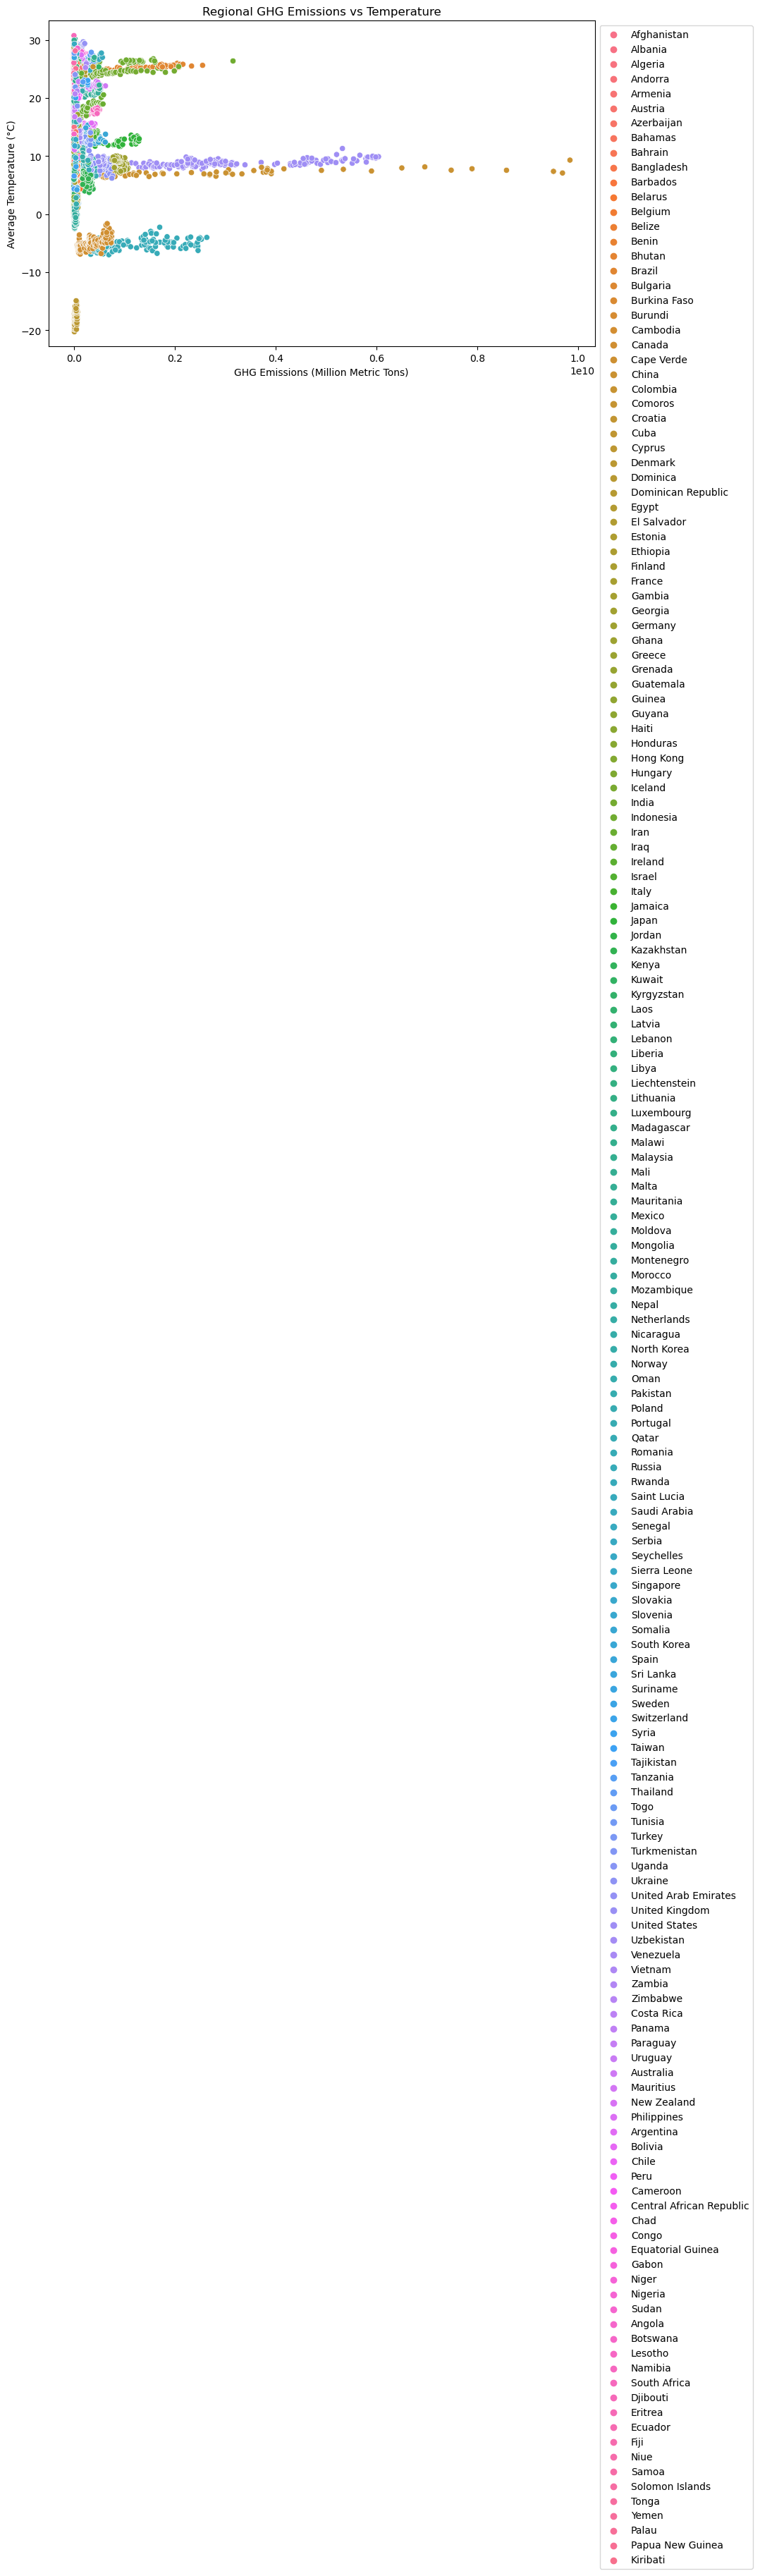

In [21]:
# Group data by region (Country)
regional_temp = combined_pd_df.groupby(['Year', 'Country']).agg({'AvgTemperature': 'mean'}).reset_index()
regional_ghg = combined_pd_df.groupby(['Year', 'Country']).agg({'GHG_Emissions': 'sum'}).reset_index()

# Joining, the regional datasets
regional_combined = pd.merge(regional_temp, regional_ghg, on=['Year', 'Country'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=regional_combined, x="GHG_Emissions", y="AvgTemperature", hue="Country")
plt.title("Regional GHG Emissions vs Temperature")
plt.xlabel("GHG Emissions (Million Metric Tons)")
plt.ylabel("Average Temperature (°C)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


# Patterns and trends in the data related to climate change variables:

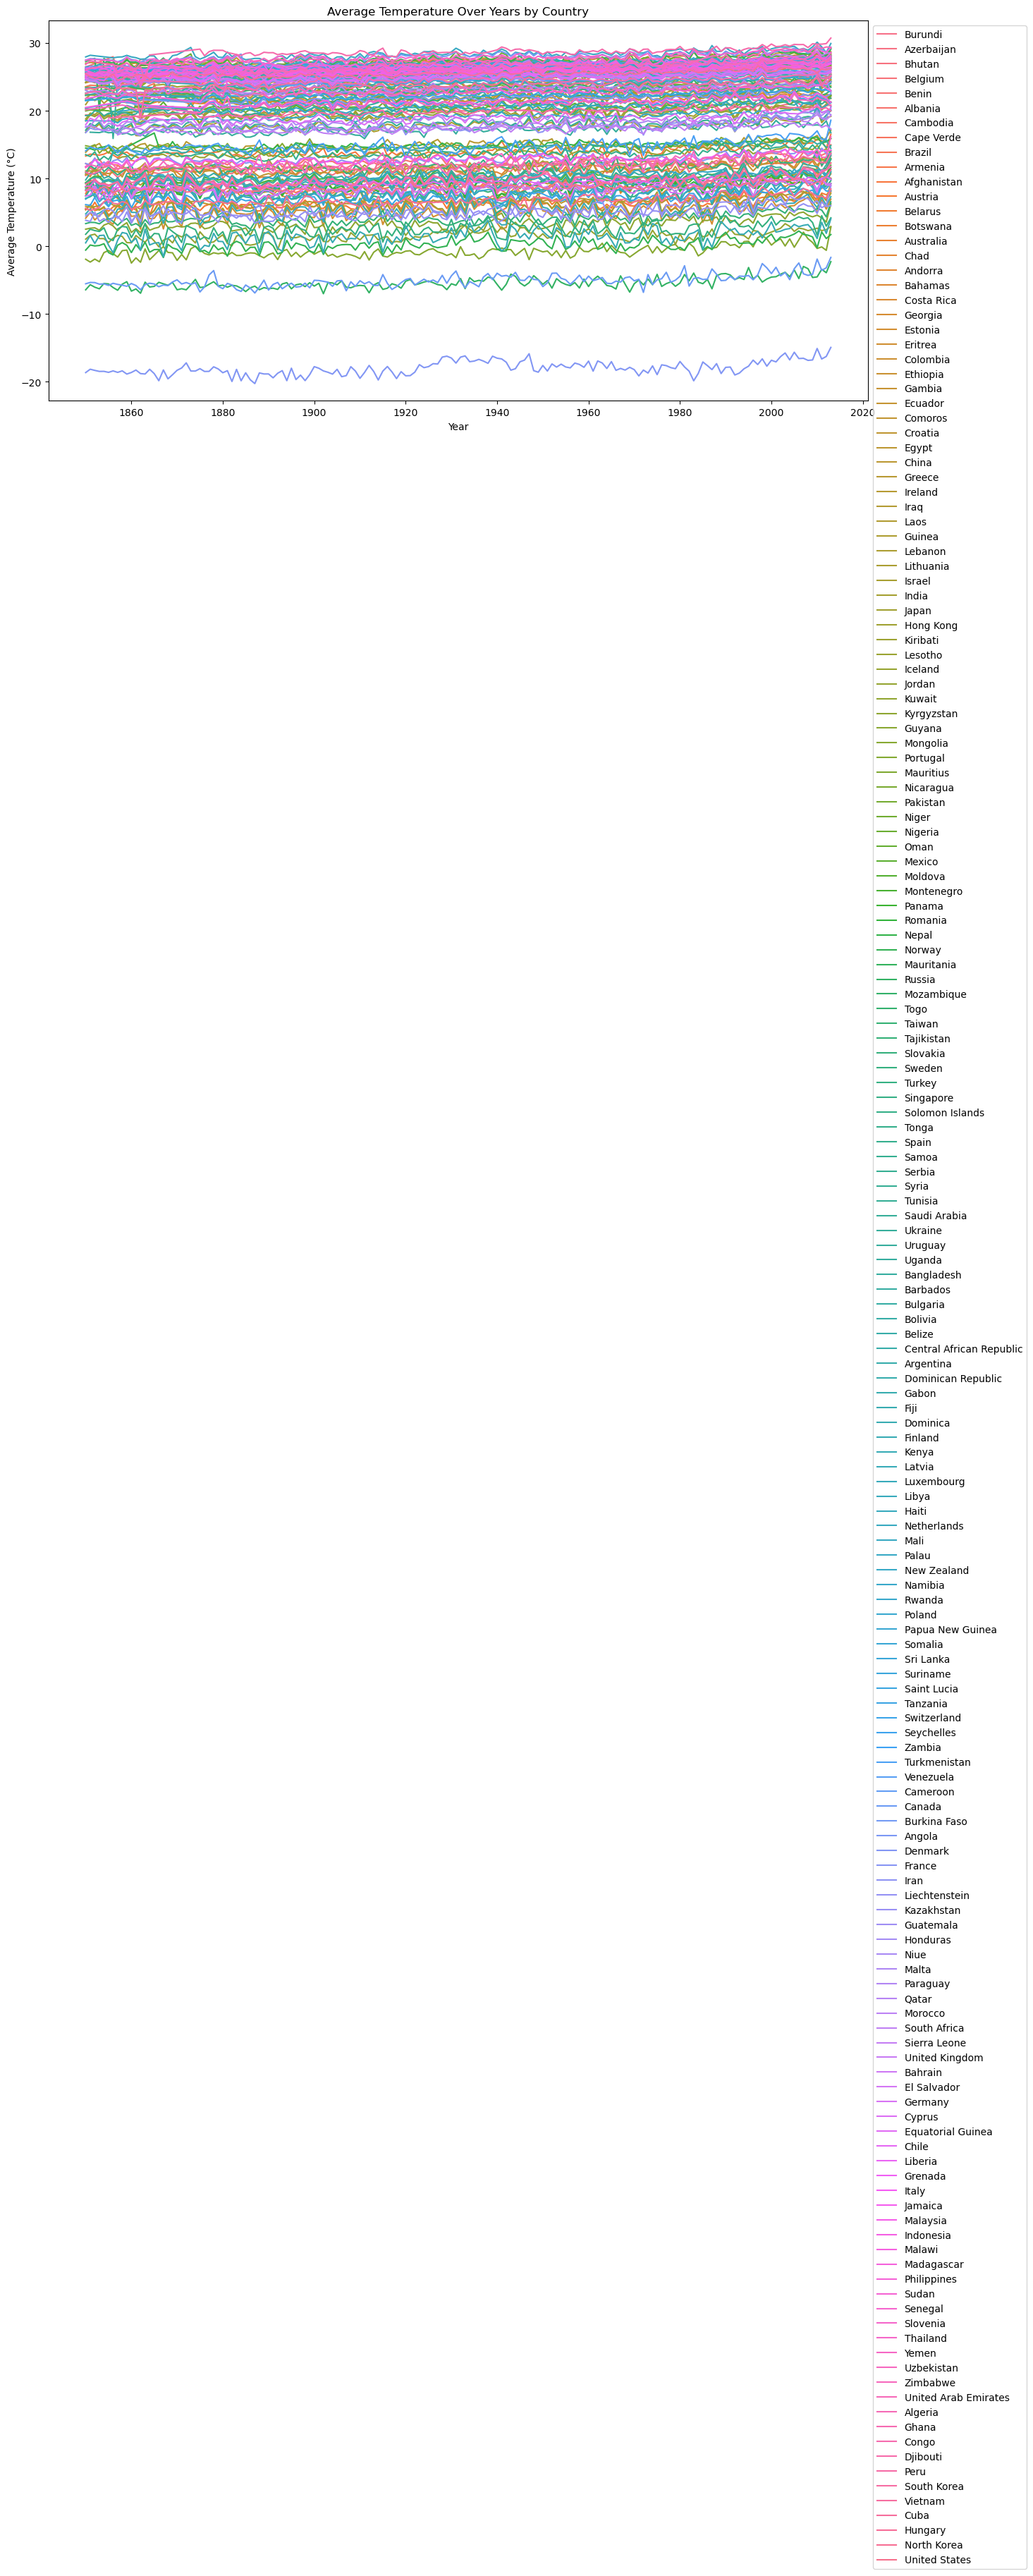

<Axes: xlabel='Year', ylabel='GHG_Emissions'>

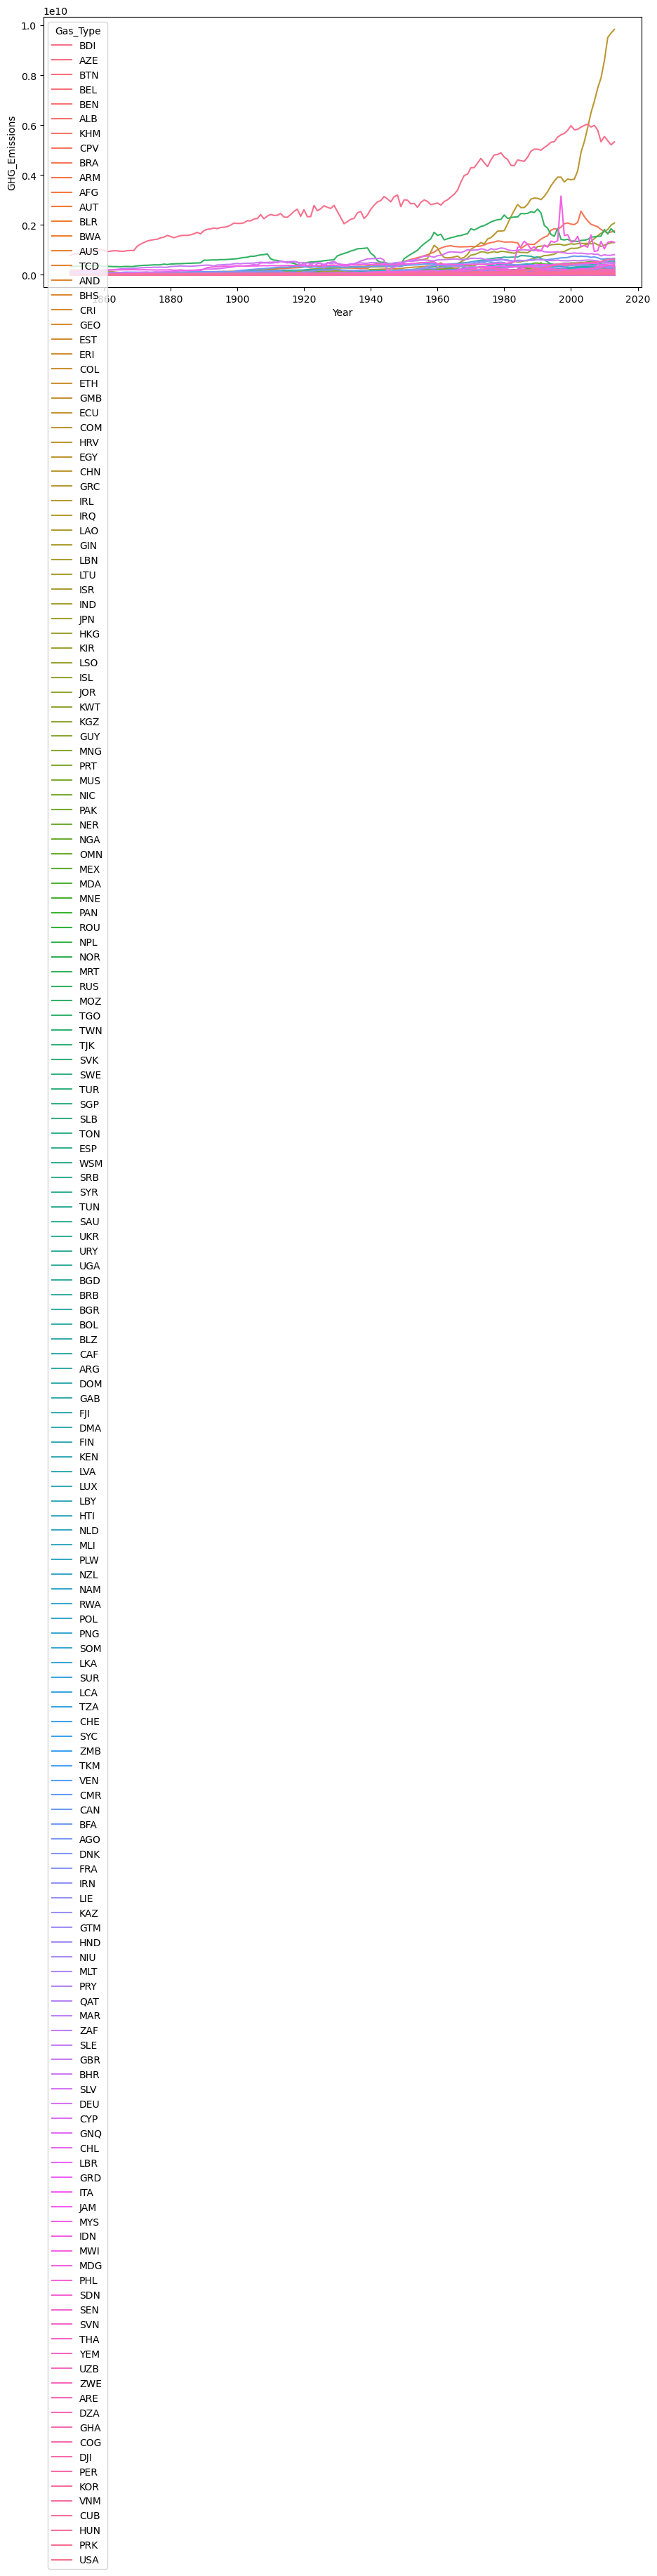

In [22]:
# Time series analysis
plt.figure(figsize=(15, 7))
sns.lineplot(data=combined_pd_df, x="Year", y="AvgTemperature", hue="Country")
plt.title("Average Temperature Over Years by Country")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

plt.figure(figsize=(11, 5))
sns.lineplot(data=combined_pd_df, x="Year", y="GHG_Emissions", hue="Gas_Type")


# Linear Regression Analysis

In [23]:

import statsmodels.api as sm

# Prepare data for regression
X = combined_pd_df["GHG_Emissions"]
y = combined_pd_df["AvgTemperature"]


# Add constant to predictor variable
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the regression statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         AvgTemperature   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     688.1
Date:                Mon, 20 May 2024   Prob (F-statistic):          8.59e-150
Time:                        01:59:36   Log-Likelihood:                -97138.
No. Observations:               27135   AIC:                         1.943e+05
Df Residuals:                   27133   BIC:                         1.943e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            18.6525      0.054    345.678

In [24]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Feature Selection and Assembling
assembler = VectorAssembler(inputCols=["AvgTemperature", "Annual nitrous oxide emissions in CO₂ equivalents"], outputCol="features")
assembled_df = assembler.transform(combined_df)


# Normalization

In [25]:
# Normalization
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)


# preprocessed data

In [26]:

scaled_df.select("Year", "Country", "scaledFeatures").show()

+----+-----------+--------------------+
|Year|    Country|      scaledFeatures|
+----+-----------+--------------------+
|2001|    Burundi|[2.33386212552253...|
|1917| Azerbaijan|[1.35206670227103...|
|1977|     Bhutan|[1.36601540774731...|
|1989|    Belgium|[1.24271492011437...|
|1998|      Benin|[3.19618797685313...|
|1890|    Albania|[1.38147182510036...|
|1938|   Cambodia|[3.03657913213748...|
|1919| Cape Verde|[2.77293816792471...|
|1885|     Brazil|[2.76637630239814...|
|1994|    Albania|[1.60439508617570...|
|2005|    Armenia|[1.10778893084042...|
|1870|Afghanistan|[1.57022028363559...|
|1879|    Austria|[0.58029838819295...|
|1857|Afghanistan|[1.48773232378641...|
|1921|    Belarus|[0.70679446640747...|
|1933|   Botswana|[2.50753346529006...|
|1936|  Australia|[2.47109235370248...|
|1970|    Burundi|[2.28204045629896...|
|1885|       Chad|[2.99909494944018...|
|1899|    Albania|[1.43216508103250...|
+----+-----------+--------------------+
only showing top 20 rows



# Caching the DataFrame

In [27]:


scaled_df.cache()

DataFrame[Year: int, Country: string, Code: string, Annual nitrous oxide emissions in CO₂ equivalents: double, Annual methane emissions in CO₂ equivalents: double, Annual CO₂ emissions: double, AvgTemperature: double, features: vector, scaledFeatures: vector]

# Map reduce Function

In [28]:
# Define the Map and Reduce functions
def map_function(row):
    return (row["Country"], (row["scaledFeatures"], 1))

def reduce_function(value1, value2):
    summed_features = value1[0] + value2[0]
    count = value1[1] + value2[1]
    return (summed_features, count)


# Converting DataFrame to RDD

In [29]:

rdd = scaled_df.rdd.map(map_function)


In [30]:
# Apply reduceByKey to aggregate data
reduced_rdd = rdd.reduceByKey(reduce_function)


In [31]:
# Calculate averages
average_rdd = reduced_rdd.mapValues(lambda x: x[0] / x[1])


In [32]:
# Convert RDD back to DataFrame
average_df = average_rdd.toDF(["Country", "AverageScaledFeatures"])


# Result

In [33]:

average_df.show()

+------------+---------------------+
|     Country|AverageScaledFeatures|
+------------+---------------------+
|  Kyrgyzstan| [0.37583387201541...|
|       Tonga| [2.64239006577483...|
|Turkmenistan| [1.69459327271055...|
|  Uzbekistan| [1.40986255549349...|
|      Canada| [-0.5725214951553...|
|     Albania| [1.44802447422253...|
|    Ethiopia| [2.61861698820571...|
|     Comoros| [2.92623003085235...|
|     Liberia| [2.88771268407729...|
|     Somalia| [3.05833030053010...|
|     Algeria| [2.62892144388220...|
|       China| [0.76022595746233...|
| El Salvador| [2.83952208797955...|
|    Malaysia| [2.93997902821517...|
|       Sudan| [3.08095906064377...|
|     Bahrain| [2.95377735474683...|
|  Costa Rica| [2.91495614873373...|
|    Kiribati| [3.04257956797883...|
|      Turkey| [1.33917861624603...|
|     Namibia| [2.33083517785655...|
+------------+---------------------+
only showing top 20 rows

